### Import libraries

In [ ]:
import os
import time 

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
# We are using 2.9.2 but it is suggested to use 2.10
print(tf.__version__)

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Import the dataset

In [ ]:
# Dataset folders 
dataset_dir = '/gdrive/My Drive/training_data_final'

In [ ]:
# Images are divided into folders, one for each class.
# So we are using the utility ImageDataGenerator.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create an instance of ImageDataGenerator for training and validation sets
train_data_gen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.2)

batch_size = 64

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               seed=seed,
                                               subset='training',
                                               shuffle=True)



val_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               seed=seed,
                                               subset='validation',
                                               shuffle=True)



Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.



### Models metadata

In [ ]:
input_shape = (96, 96, 3)
epochs = 200


### CNN Model

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)


    flattening_layer = tfkl.Flatten(name='Flatten')(pool4)
    dropout = tfkl.Dropout(0.6, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=160, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.6, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)       73856 

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_callbacks():

  callbacks = []

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = create_callbacks()
).history

Epoch 1/200
45/45 [==============================] - 6s 118ms/step - loss: 2.3907 - accuracy: 0.1834 - val_loss: 1.8348 - val_accuracy: 0.2578
Epoch 2/200
45/45 [==============================] - 5s 112ms/step - loss: 1.8409 - accuracy: 0.2743 - val_loss: 1.6853 - val_accuracy: 0.3414
Epoch 3/200
45/45 [==============================] - 5s 112ms/step - loss: 1.6505 - accuracy: 0.3449 - val_loss: 1.5154 - val_accuracy: 0.3924
Epoch 4/200
45/45 [==============================] - 5s 112ms/step - loss: 1.5448 - accuracy: 0.4133 - val_loss: 1.4849 - val_accuracy: 0.4363
Epoch 5/200
45/45 [==============================] - 5s 117ms/step - loss: 1.4739 - accuracy: 0.4531 - val_loss: 1.5045 - val_accuracy: 0.4731
Epoch 6/200
45/45 [==============================] - 5s 112ms/step - loss: 1.4039 - accuracy: 0.4644 - val_loss: 1.4864 - val_accuracy: 0.4008
Epoch 7/200
45/45 [==============================] - 5s 111ms/step - loss: 1.3789 - accuracy: 0.4803 - val_loss: 1.4769 - val_accuracy: 0.4476

### Save the model

In [ ]:
model.save('SubmissionModel')

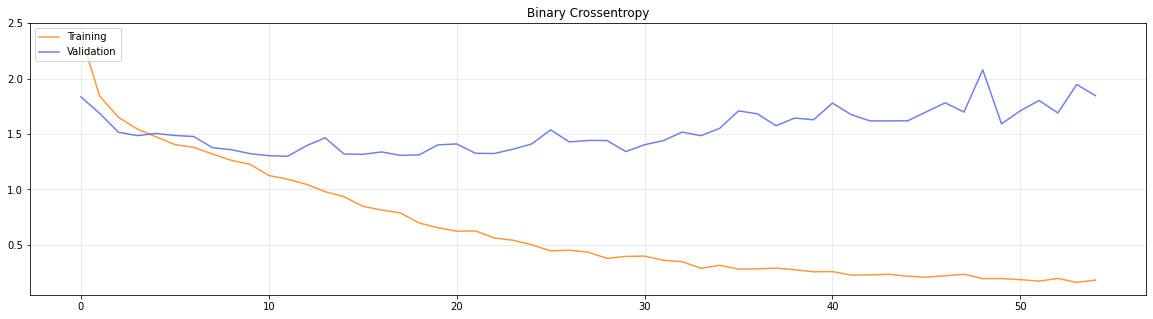

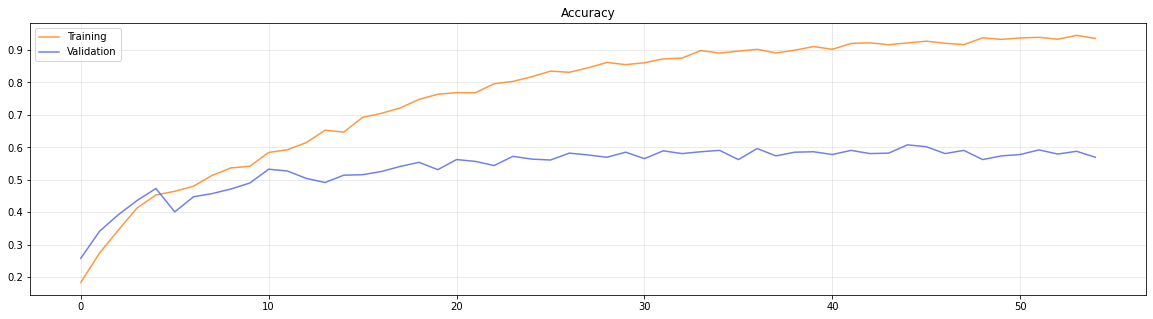

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
import os
import zipfile

folder = 'SubmissionModel'

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
zipf = zipfile.ZipFile('model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir(folder, zipf)
zipf.close()